In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import seaborn as sns
import operator
import re
import calendar
from collections import Counter
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12,7
plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

In [2]:
data = pd.read_pickle('master_VGC22')

In [73]:
data.head()

,Console,CriticScore,Date,Developer,Game,Id,JAP,NA,Other,PAL,Publisher,Total,UserScore,VGCScore,Day,Month,Year
0,Wii,NAN,19th Nov 06,Nintendo EAD,Wii Sports,1,29.02,82.65,3.77,41.36,Nintendo,NAN,7.7,NAN,19,11,2006
1,NES,NAN,18th Oct 85,Nintendo EAD,Super Mario Bros.,2,3.58,40.24,6.81,29.08,Nintendo,NAN,10,NAN,18,10,1985
2,Wii,8.7,27th Apr 08,Nintendo EAD,Mario Kart Wii,3,12.92,35.9,3.8,15.84,Nintendo,9.1,8.2,NAN,27,4,2008
3,Wii,8.8,26th Jul 09,Nintendo EAD,Wii Sports Resort,4,10.98,32.9,3.29,15.61,Nintendo,8.8,8,NAN,26,7,2009
4,GB,NAN,30th Sep 98,Game Freak,Pok�mon Red / Green / Blue Version,5,8.89,31.37,10.22,11.27,Nintendo,NAN,9.4,NAN,30,9,1998


In [40]:
def clean_date(date):
    try:
        dmy = re.split(' ',date)
        d = int(dmy[0][:-2])
        nametonum = {v: k for k,v in enumerate(calendar.month_abbr)}
        m = nametonum[dmy[1]]
        if dmy[2][0] == '0':
            y = int('20'+dmy[2])
        else:
            y = int('19'+dmy[2])
        return d,m,y
    except:
        return None,None,None
cdate = [clean_date(date) for date in list(data.Date)]
data['Day'],data['Month'],data['Year']=zip(*cdate)

In [68]:
iiigen = data[data.Year < 1989]
iiigen = iiigen[iiigen.Year > 1983]

In [69]:
cons = ['5200',
 '7800',
 'ACPC',
 'AST',
 'Aco',
 'Amig',
 'Arc',
 'BBCM',
 'BRW',
 'C128',
 'C64',
 'MS',
 'MSX',
 'NES',
 'PCE',
 'TG16',
 'ZXS']

In [70]:
iiigen = iiigen[iiigen.Console.isin(cons)]

In [84]:
devs_in_time = {}
for c in set(iiigen.Console):
    devs_in_time[c] = []    
    consdf = iiigen[iiigen.Console == c]
    mint = min(consdf.Year)
    maxt = max(consdf.Year)
    print mint, maxt
    devs_in_time[c] = [len(set(consdf[consdf.Year == y].Developer)) for y in range(1983,1989)]
        
        

1986 1988
1984 1984
1985 1988
1987 1987
1986 1988
1985 1988
1984 1984
1984 1988
1984 1987
1985 1985
1985 1987
1985 1988
1984 1988
1984 1988
1984 1988
1987 1988


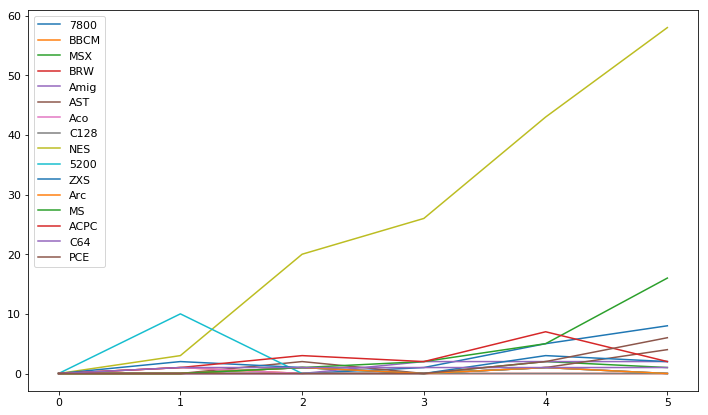

In [85]:
for i in devs_in_time.keys():
    plt.plot(devs_in_time[i],label=i)
plt.legend(loc=2)
plt.show()
    

In [86]:
nes = iiigen[iiigen.Console == 'NES']

In [94]:
nesdev = pd.DataFrame.from_dict(Counter(nes.Developer),orient='index')#,index=range(len(set(nes.Developer))))

In [101]:
nesdev = nesdev.sort_values(by=0,ascending=False)

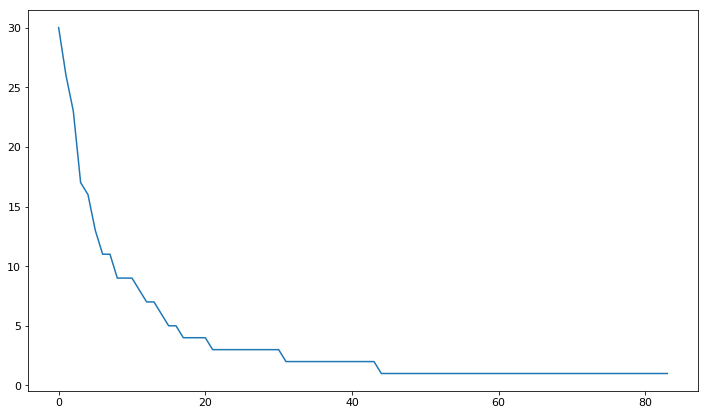

In [104]:
plt.plot(list(nesdev[0]))
plt.show()